## Setup

In [1]:
! pip install neuralogic
from neuralogic.nn import get_evaluator
from neuralogic.core import R, Template, V, Transformation, Aggregation, Combination
from neuralogic.core.settings import Settings
from neuralogic.dataset import Dataset
from neuralogic.optim import SGD
from neuralogic.utils.data import Mutagenesis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 23.3 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/neuralogic/core/builder/builder.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Dataset definition

In [35]:
_, dataset = Mutagenesis()

template = Template()

template.add_rules([
    (R.atom_embed(V.A)[3,] <= R.get(atom)(V.A)) for atom in ["c", "o", "br", "i", "f", "h", "n", "cl"]
])


template.add_rules([
    (R.bond_embed(V.B)[3,] <= R.get(bond)(V.B)) for bond in ["b_1", "b_2", "b_3", "b_4", "b_5", "b_7"]
])

## Gated GNN rules

In [31]:
def get_gated_gnn(layer_name, node_embed, edge_embed, connection, param_size, max_depth=1):
  template = []
  template += [(R.get(layer_name + "_h")(V.X, 0) <= (R.get(node_embed)(V.X)[param_size]))]

  template += [(R.get(layer_name + "_a_in")(V.X, V.T) <= (R.get(connection)(V.X, V.Y, V.B), 
                                                          R.get(edge_embed)(V.B)[param_size], 
                                                          R.get(layer_name + "_h")(V.Y, V.Z)[param_size], 
                                                          R.special.next(V.Z, V.T))) | [Aggregation.SUM, Transformation.IDENTITY]]
  
  template += [(R.get(layer_name + "_a_out")(V.X, V.T) <= (R.get(connection)(V.X, V.Y, V.B), 
                                                           R.get(edge_embed)(V.B)[param_size], 
                                                           R.get(layer_name + "_h")(V.Y, V.Z)[param_size], 
                                                           R.special.next(V.Z, V.T))) | [Aggregation.SUM, Transformation.IDENTITY]]


  template += [(R.get(layer_name + "_update_gate")(V.X, V.T) <= (R.get(layer_name + "_a_in")(V.X, V.T)[param_size], 
                                                                 R.get(layer_name + "_a_out")(V.X, V.T)[param_size], 
                                                                 R.get(layer_name + "_h")(V.X, V.Z)[param_size], 
                                                                 R.special.next(V.Z, V.T))) | [Transformation.SIGMOID]]

  template += [(R.get(layer_name + "_reset_gate")(V.X, V.T) <= (R.get(layer_name + "_a_in")(V.X, V.T)[param_size], 
                                                                R.get(layer_name + "_a_out")(V.X, V.T)[param_size], 
                                                                R.get(layer_name + "_h")(V.X, V.Z)[param_size], 
                                                                R.special.next(V.Z, V.T))) | [Transformation.SIGMOID]]


  template += [(R.get(layer_name + "_h_tright")(V.X, V.T) <= (R.get(layer_name + "_reset_gate")(V.X, V.T),
                                                              R.get(layer_name + "_h")(V.X, V.Z),
                                                              R.special.next(V.Z, V.T))) | [Transformation.IDENTITY, Combination.ELPRODUCT]]

  template += [(R.get(layer_name + "_h_tilde")(V.X, V.T) <= (R.get(layer_name + "_a_in")(V.X, V.T)[param_size],
                                                             R.get(layer_name + "_a_out")(V.X, V.T)[param_size],
                                                             R.get(layer_name + "_h_tright")(V.X, V.T)[param_size])) | [Transformation.TANH, Aggregation.SUM]]

  template += [(R.get(layer_name + "_h_right")(V.X, V.T) <= (R.get(layer_name + "_update_gate")(V.X, V.T),
                                                             R.get(layer_name + "_h_tilde")(V.X, V.T))) | [Transformation.IDENTITY, Combination.ELPRODUCT]]

  template += [(R.get(layer_name + "_h_left")(V.X, V.T) <= (R.get(layer_name + "_update_gate")(V.X, V.T),
                                                            R.get(layer_name + "_h")(V.X, V.Z),
                                                            R.special.next(V.Z, V.T))) | [Transformation.IDENTITY, Combination.ELPRODUCT]]

  template += [(R.get(layer_name + "_h")(V.X, V.T) <= (R.get(layer_name + "_h_left")(V.X, V.T),
                                                       R.get(layer_name + "_h_right")(V.X, V.T))) | [Aggregation.SUM, Transformation.IDENTITY]]
  
  for i in range(max_depth):
    template += [(R._next(i, i + 1))]

  template += [(R.get(layer_name)(V.X) <= R.get(layer_name + "_h")(V.X, max_depth))]
  return template

In [32]:
max_depth = 10
#template += (R._next(i, i + 1) for i in range(max_depth +1))
template += get_gated_gnn("l1", "atom_embed", "bond_embed", "bond", (3, 3), max_depth=max_depth)
template += (R.predict[1, 3] <= R.l1(V.X))

In [36]:
################## CONTROL #######################

template += R.get("h")(V.X, 0) <= (R.get("atom_embed")(V.X)[3,3])

template += (R.get("activation_in")(V.X, V.T) <= (R.get("bond")(V.X, V.Y, V.B), R.get("bond_embed")(V.B)[3,3], R.get("h")(V.Y, V.Z)[3,3], R.special.next(V.Z, V.T))) | [Aggregation.SUM, Transformation.IDENTITY]  # [D,] = infeatures(V.X, V.Y)
template += (R.get("activation_out")(V.X, V.T) <= (R.get("bond")(V.X, V.Y, V.B), R.get("bond_embed")(V.B)[3,3], R.get("h")(V.Y, V.Z)[3,3], R.special.next(V.Z, V.T))) | [Aggregation.SUM, Transformation.IDENTITY] # [D,] = outfeatures(V.X, V.Y)


template += (R.get("update_gate")(V.X, V.T) <= (R.get("activation_in")(V.X, V.T)[3, 3], R.get("activation_out")(V.X, V.T)[3, 3], R.get("h")(V.X, V.Z)[3, 3], R.special.next(V.Z, V.T))) | [Transformation.SIGMOID]

template += (R.get("reset_gate")(V.X, V.T) <= (R.get("activation_in")(V.X, V.T)[3, 3], R.get("activation_out")(V.X, V.T)[3, 3], R.get("h")(V.X, V.Z)[3, 3], R.special.next(V.Z, V.T))) | [Transformation.SIGMOID]


template += (R.get("h_tright")(V.X, V.T) <= (R.get("reset_gate")(V.X, V.T), R.get("h")(V.X, V.Z), R.special.next(V.Z, V.T))) | [Transformation.IDENTITY, Combination.ELPRODUCT]

template += (R.get("h_tilde")(V.X, V.T) <= (R.get("activation_in")(V.X, V.T)[3, 3], R.get("activation_out")(V.X, V.T)[3, 3], R.get("h_tright")(V.X, V.T)[3, 3])) | [Transformation.TANH, Aggregation.SUM]

template += (R.get("h_right")(V.X, V.T) <= (R.get("update_gate")(V.X, V.T), R.get("h_tilde")(V.X, V.T))) | [Transformation.IDENTITY, Combination.ELPRODUCT]

template += (R.get("h_left")(V.X, V.T) <= (R.get("update_gate")(V.X, V.T), R.get("h")(V.X, V.Z), R.special.next(V.Z, V.T))) | [Transformation.IDENTITY, Combination.ELPRODUCT]

template += (R.get("h")(V.X, V.T) <= (R.get("h_left")(V.X, V.T), R.get("h_right")(V.X, V.T))) | [Aggregation.SUM, Transformation.IDENTITY]

In [37]:
max_depth = 10
template += (R._next(i, i + 1) for i in range(max_depth))
template += (R.l1(V.X) <= R.h(V.X, max_depth))
template += (R.predict[1, 3] <= R.l1(V.X))


{3} atom_embed(A) :- c(A).
{3} atom_embed(A) :- o(A).
{3} atom_embed(A) :- br(A).
{3} atom_embed(A) :- i(A).
{3} atom_embed(A) :- f(A).
{3} atom_embed(A) :- h(A).
{3} atom_embed(A) :- n(A).
{3} atom_embed(A) :- cl(A).
{3} bond_embed(B) :- b_1(B).
{3} bond_embed(B) :- b_2(B).
{3} bond_embed(B) :- b_3(B).
{3} bond_embed(B) :- b_4(B).
{3} bond_embed(B) :- b_5(B).
{3} bond_embed(B) :- b_7(B).
h(X, 0) :- {3, 3} atom_embed(X).
activation_in(X, T) :- bond(X, Y, B), {3, 3} bond_embed(B), {3, 3} h(Y, Z), @next(Z, T). [transformation=identity, aggregation=sum]
activation_out(X, T) :- bond(X, Y, B), {3, 3} bond_embed(B), {3, 3} h(Y, Z), @next(Z, T). [transformation=identity, aggregation=sum]
update_gate(X, T) :- {3, 3} activation_in(X, T), {3, 3} activation_out(X, T), {3, 3} h(X, Z), @next(Z, T). [transformation=sigmoid]
reset_gate(X, T) :- {3, 3} activation_in(X, T), {3, 3} activation_out(X, T), {3, 3} h(X, Z), @next(Z, T). [transformation=sigmoid]
h_tright(X, T) :- reset_gate(X, T), h(X, Z), @n

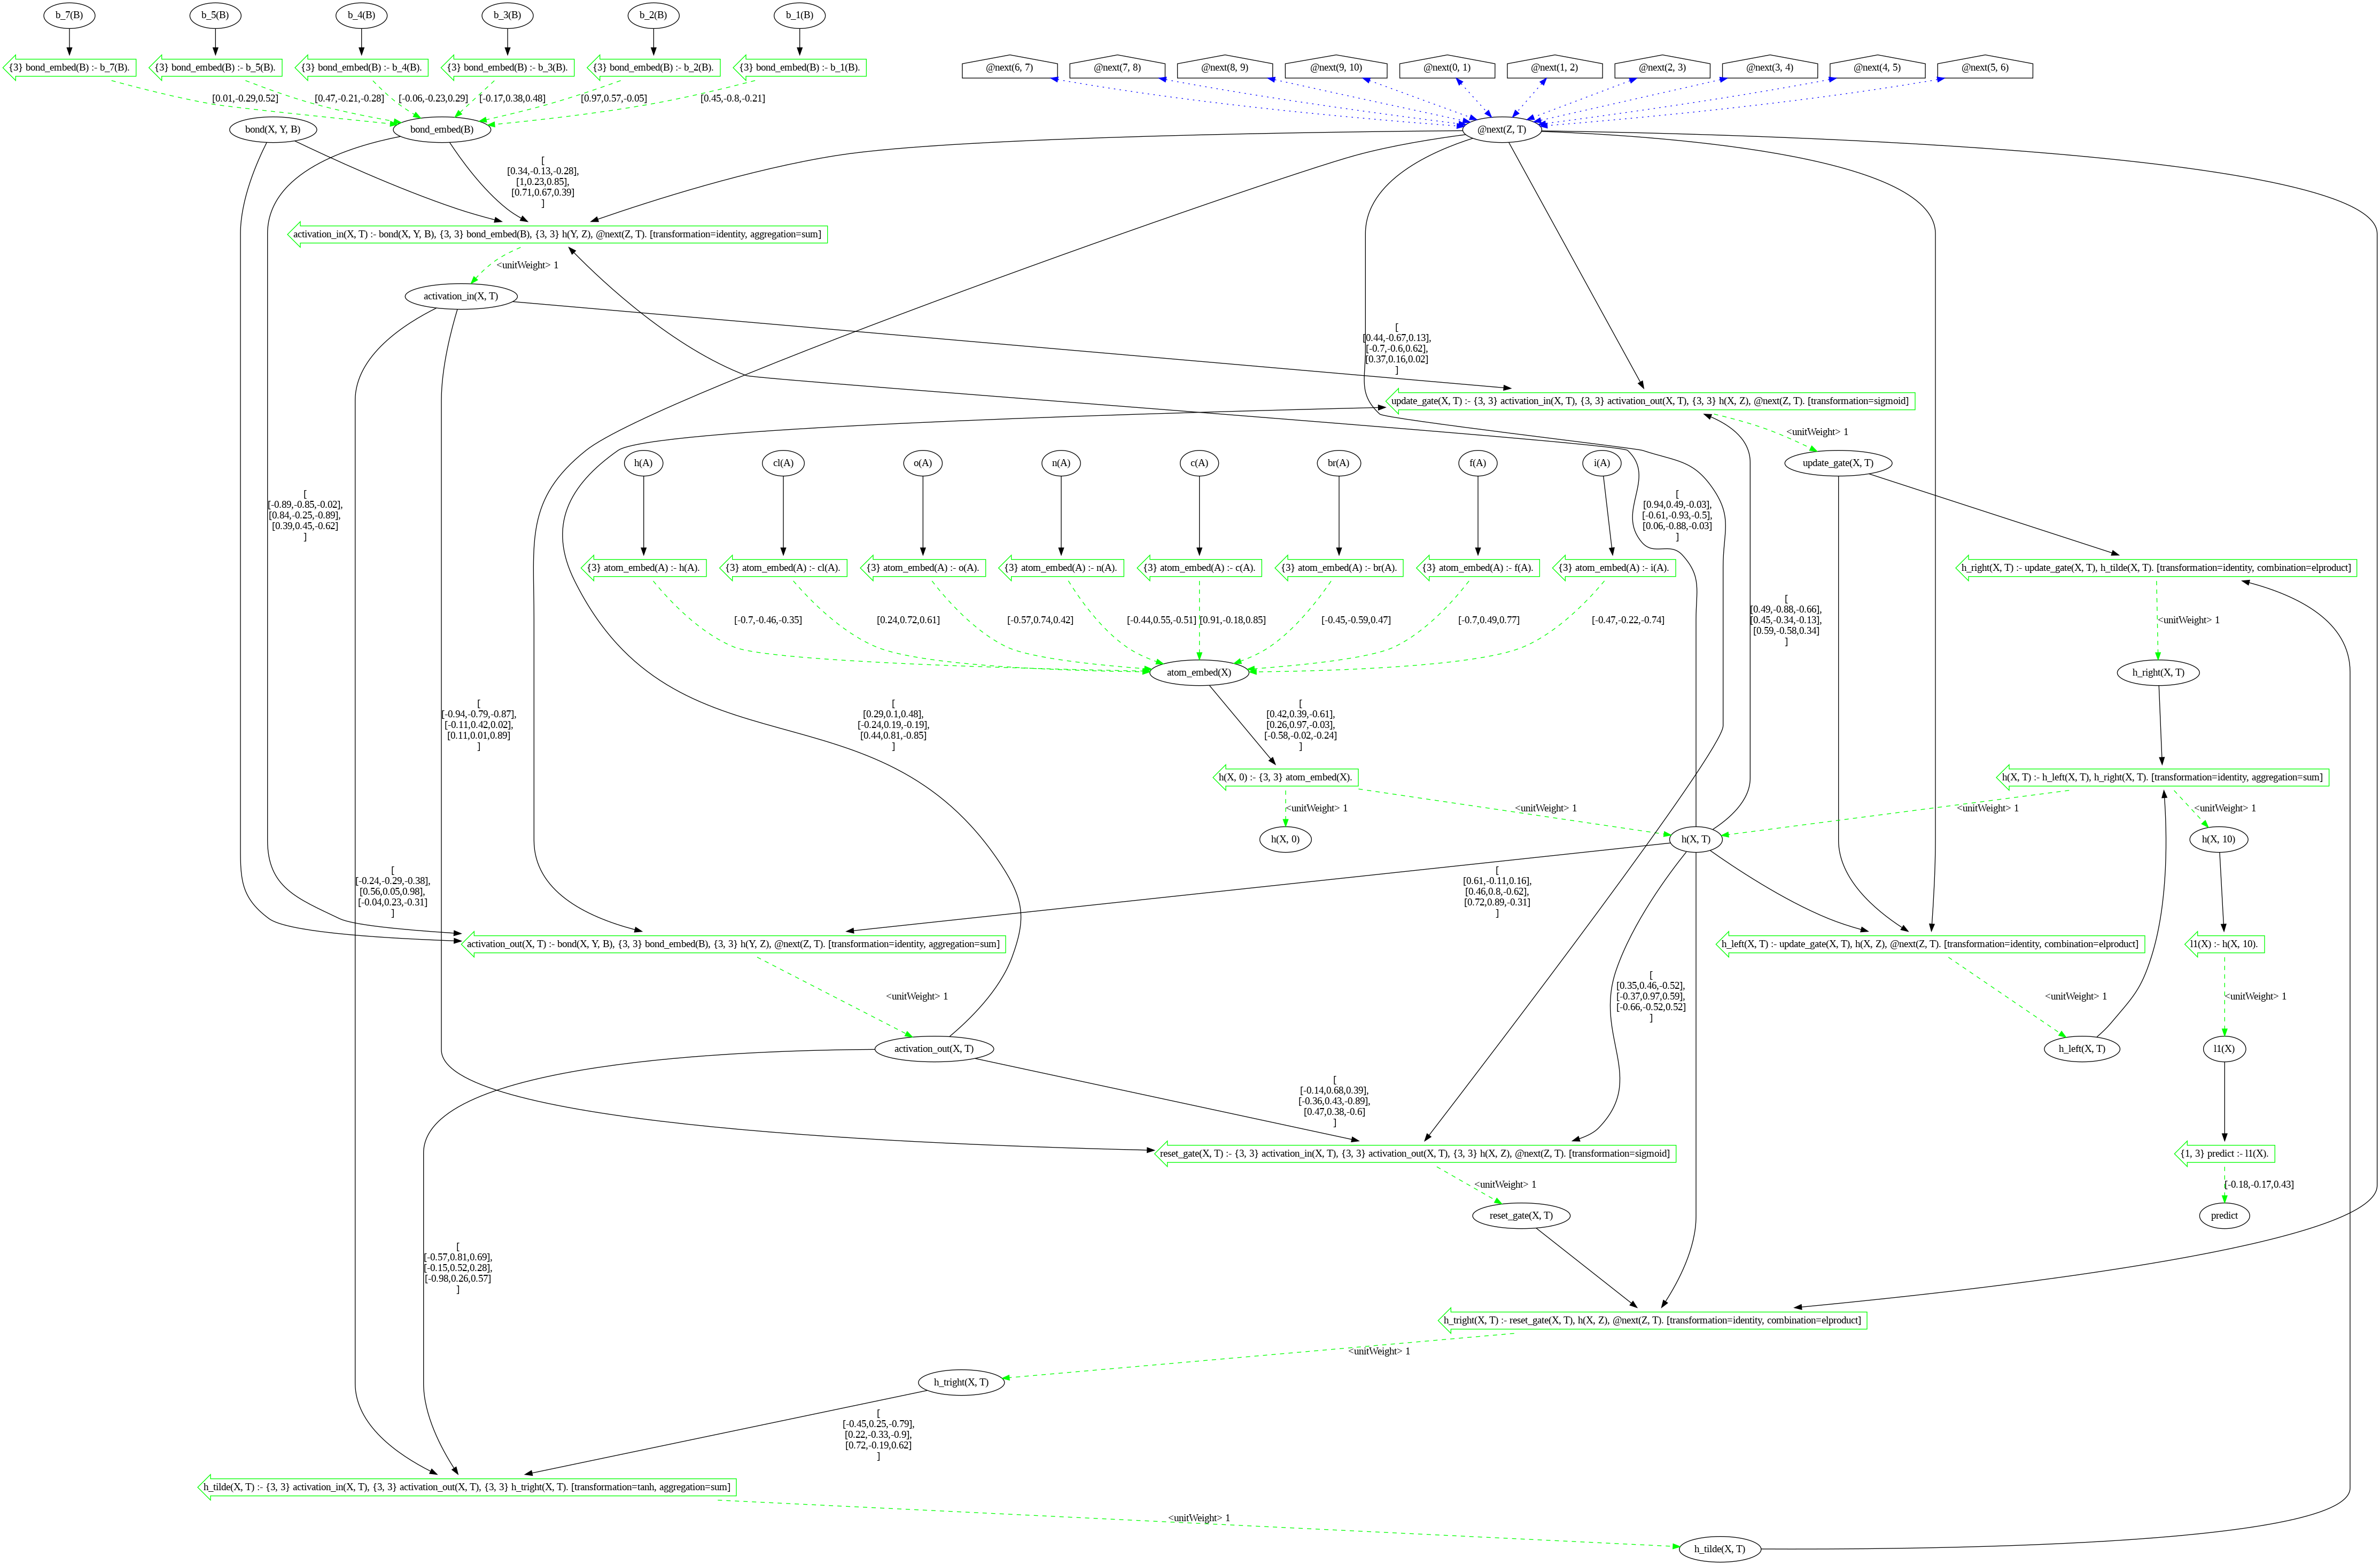

In [38]:
print(template)
template.draw()

{3} atom_embed(A) :- c(A).
{3} atom_embed(A) :- o(A).
{3} atom_embed(A) :- br(A).
{3} atom_embed(A) :- i(A).
{3} atom_embed(A) :- f(A).
{3} atom_embed(A) :- h(A).
{3} atom_embed(A) :- n(A).
{3} atom_embed(A) :- cl(A).
{3} bond_embed(B) :- b_1(B).
{3} bond_embed(B) :- b_2(B).
{3} bond_embed(B) :- b_3(B).
{3} bond_embed(B) :- b_4(B).
{3} bond_embed(B) :- b_5(B).
{3} bond_embed(B) :- b_7(B).
l1_h(X, 0) :- {3, 3} atom_embed(X).
l1_a_in(X, T) :- bond(X, Y, B), {3, 3} bond_embed(B), {3, 3} l1_h(Y, Z), @next(Z, T). [transformation=identity, aggregation=sum]
l1_a_out(X, T) :- bond(X, Y, B), {3, 3} bond_embed(B), {3, 3} l1_h(Y, Z), @next(Z, T). [transformation=identity, aggregation=sum]
l1_update_gate(X, T) :- {3, 3} l1_a_in(X, T), {3, 3} l1_a_out(X, T), {3, 3} l1_h(X, Z), @next(Z, T). [transformation=sigmoid]
l1_reset_gate(X, T) :- {3, 3} l1_a_in(X, T), {3, 3} l1_a_out(X, T), {3, 3} l1_h(X, Z), @next(Z, T). [transformation=sigmoid]
l1_h_tright(X, T) :- l1_reset_gate(X, T), l1_h(X, Z), @next(Z,

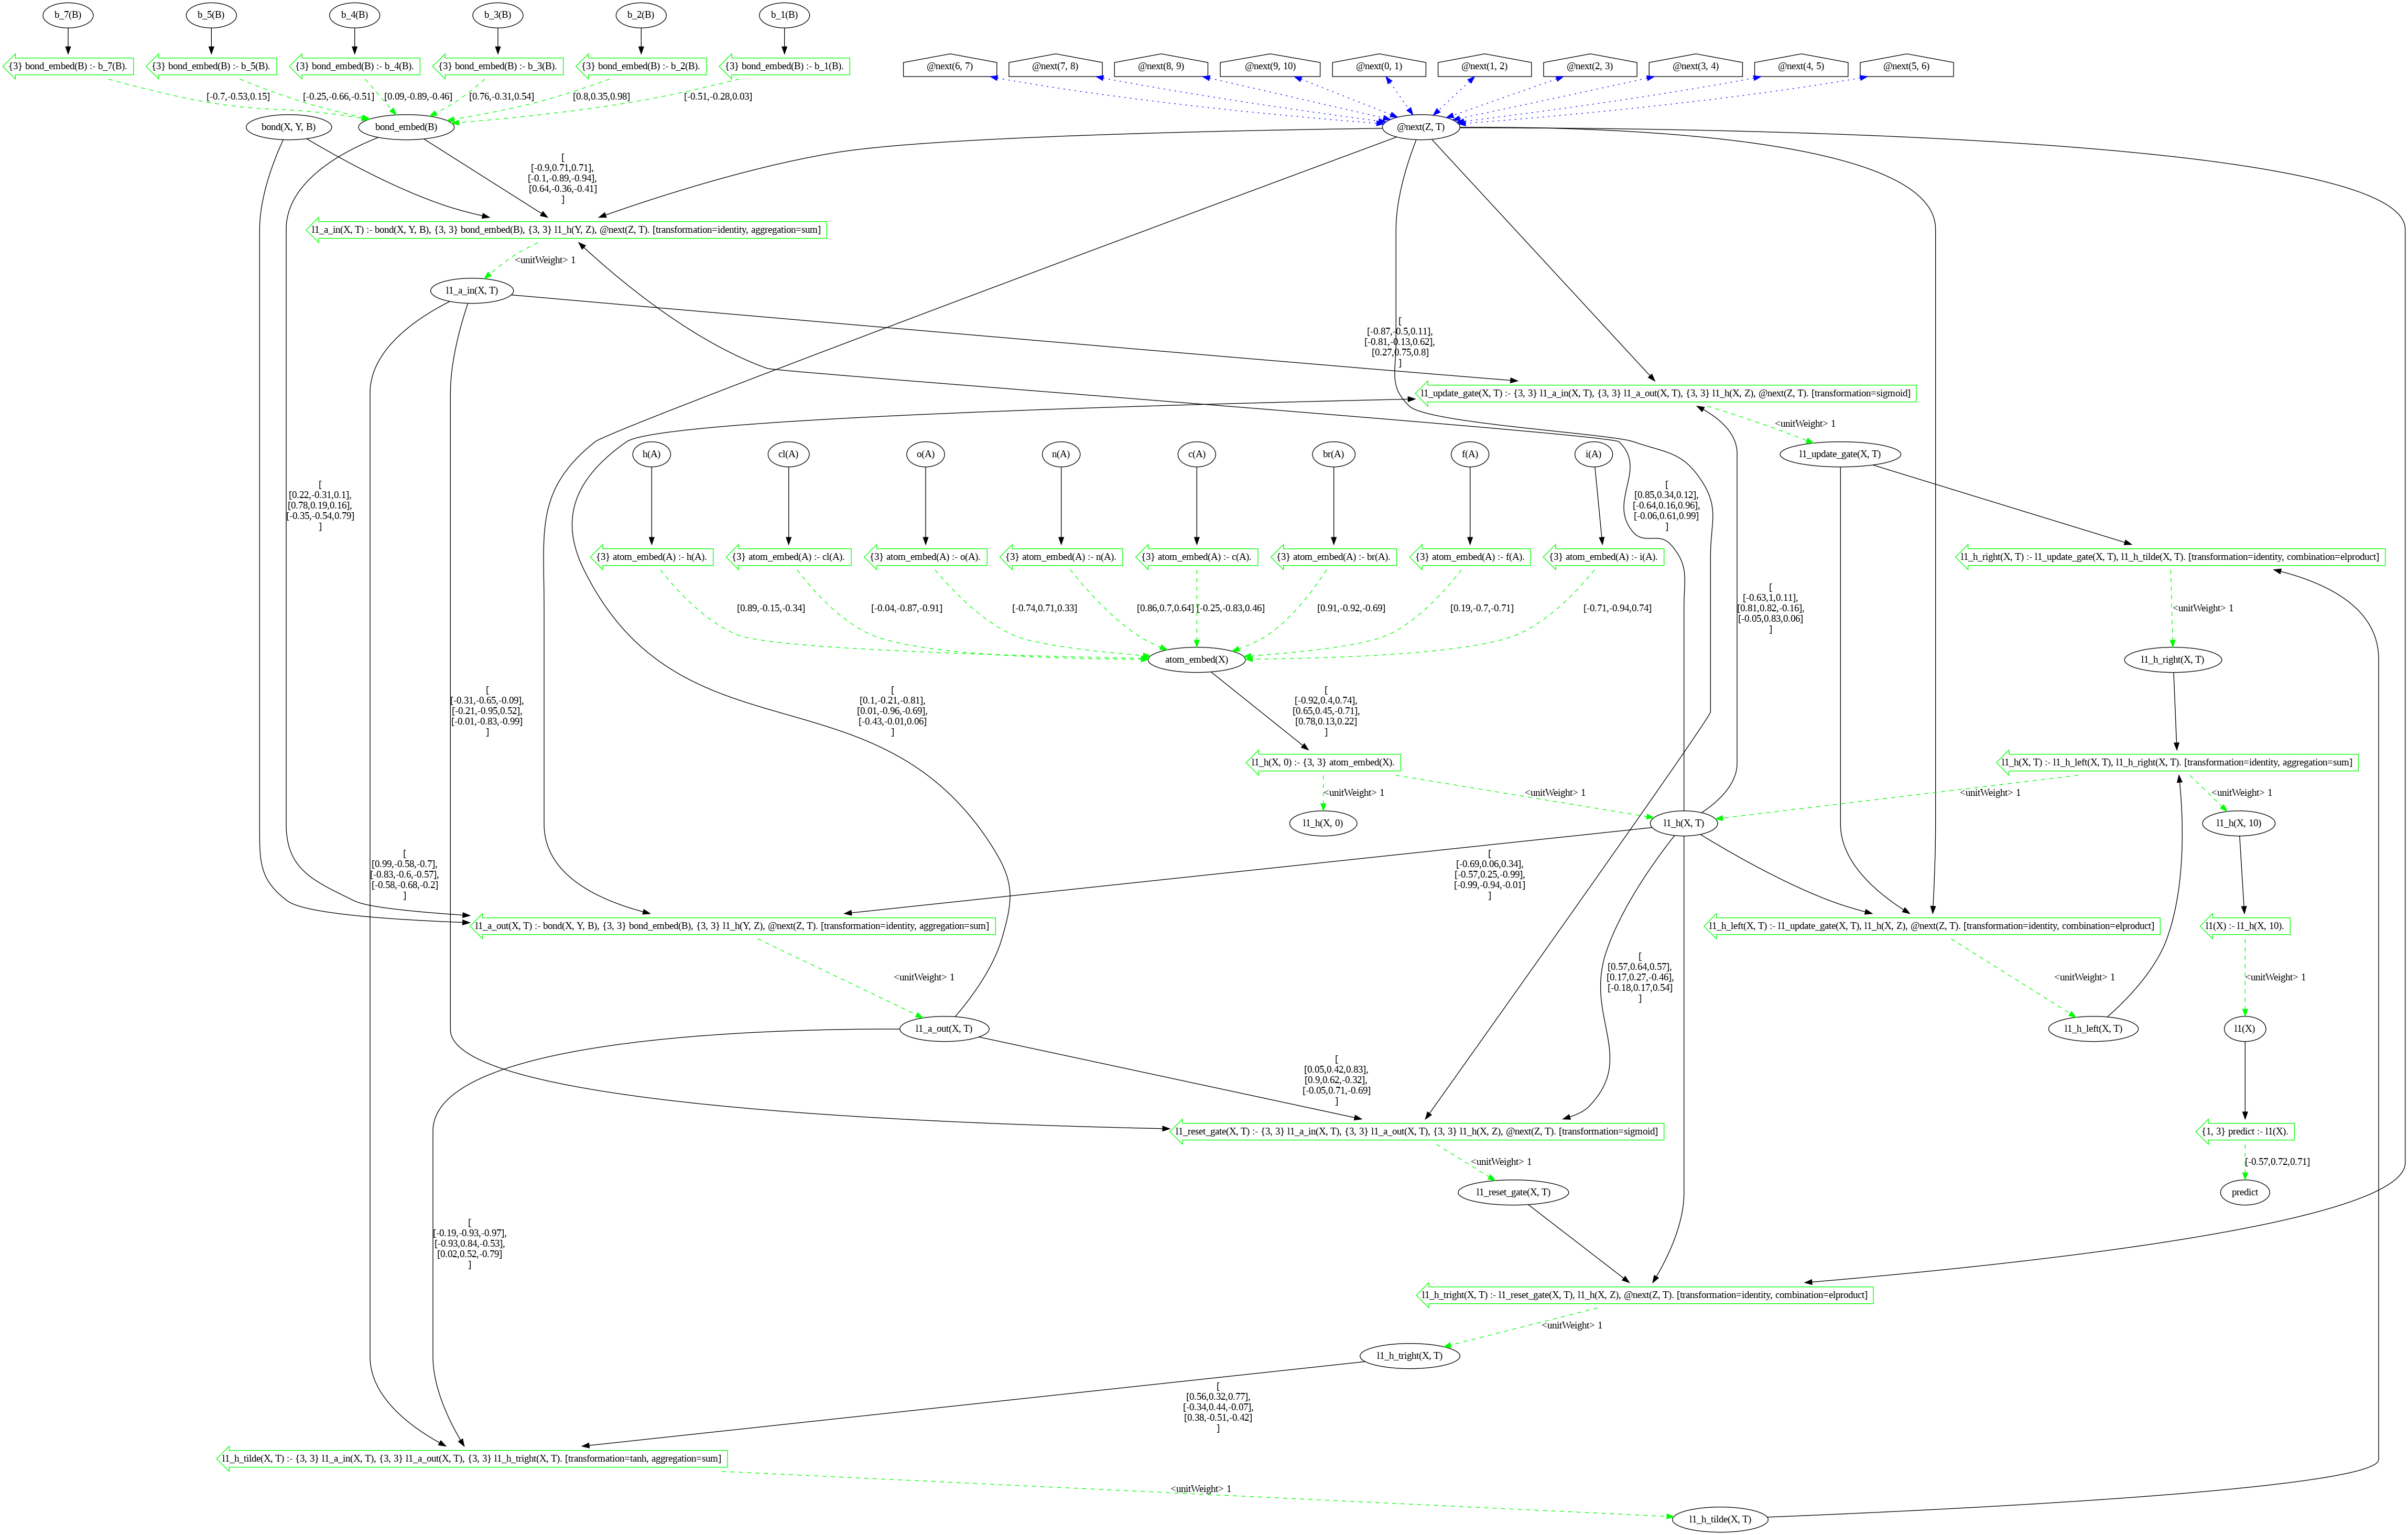

In [34]:
print(template)
template.draw()

## Training

In [28]:
from neuralogic.core import Settings
from neuralogic.nn.loss import MSE
from neuralogic.nn import get_evaluator
from neuralogic.optim import Adam
import random
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_test_cycle(template, dataset, lr=0.001, epochs=100, split=0.75):
  settings = Settings(optimizer=Adam(lr=lr), epochs=epochs, error_function=MSE())
  evaluator = get_evaluator(template, settings)

  built_dataset = evaluator.build_dataset(dataset)
  dataset_len = len(built_dataset.samples)

  train_size = int(dataset_len*split)

  idx = random.sample(list(range(dataset_len)), train_size)
  rest = list(set(range(dataset_len)) - set(idx))
  train_dataset = np.array(built_dataset.samples)[idx]
  test_dataset = np.array(built_dataset.samples)[rest]
  average_losses = []

  for current_total_loss, number_of_samples in evaluator.train(train_dataset):
      clear_output(wait=True)
      plt.ylabel("Loss")
      plt.xlabel("Epoch")

      plt.xlim(0, settings.epochs)
      
      train_loss = current_total_loss/number_of_samples
      print(train_loss)

      average_losses.append(train_loss)
      
      plt.plot(average_losses, label="Average loss")

      plt.legend()
      plt.pause(0.001)
      plt.show()

  loss = []
  for sample, y_hat in zip(test_dataset, evaluator.test(test_dataset, generator=False)):
      loss.append(round(y_hat) != sample.java_sample.target.value)

  test_loss = sum(loss) / len(test_dataset)

  return train_loss, test_loss, evaluator


0.17021276899782264


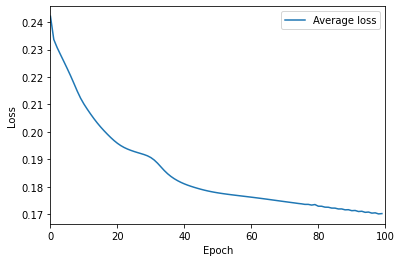

0.2553191489361702

In [33]:
test_losses = []
for i in range(1):
  print("Training and testing model #{}".format(i))
  train_loss, test_loss, eval = train_test_cycle(template, dataset)
  test_losses.append(test_loss)

np.average(test_losses)